<a href="https://colab.research.google.com/github/joey0320/reversemethod/blob/colabcodes/RM_USING_EXCEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#!git clone https://github.com/joey0320/reversemethod.git

In [0]:
#!git clone https://github.com/joey0320/reversemethod.git

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon Apr 13 15:02:03 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset
import matplotlib.pyplot as plt
import math
import os
from tqdm import tqdm
import time
import cv2
#from DataCaller_Excel import DataCaller_Excel
#from Model import Net
#from EarlyStop import EarlyStopping

#use gpu    please somebody buy me a gpu .......
USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

#Global variables
LOAD_DATA = True
BATCH_SIZE = 32
VAL_BATCH_SIZE = 32
LEARNING_RATE = 1e-5
EPOCHS = 1000
PATIENCE = 25
VALIDATE_EVERY = 10
MODEL_NAME = f"model-{int(time.time())}"
IMG_SIZE = 64
IMG_CHANNELS = 1
OUTPUT_LABEL_SIZE = 4
OUTPUT_AB = 42
OUTPUT_Y = 1
OUTPUT_D = 5

cuda


In [0]:

class DataCaller_Excel(Dataset):
    def __init__(self, data_path, inputsize):
        
        self.data_path = data_path
        self.inputsize = inputsize
        
        data = pd.read_excel(open(self.data_path, 'rb'), sheet_name='Sheet1', header=None)
        data = np.array(data)
        data = data.reshape(-1, 1, inputsize, inputsize)
        self.data = torch.from_numpy(data).float()
        
        label = pd.read_excel(open(self.data_path, 'rb'), sheet_name='Sheet2', header=None)
        self.label = torch.from_numpy( np.array(label) ).float()
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        x = torch.FloatTensor(self.data[idx])
        y = torch.FloatTensor(self.label[idx])
        return x, y

In [0]:

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = - val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

In [0]:
import torch
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.cnn = nn.Sequential(
            nn.Conv2d(IMG_CHANNELS, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            #nn.BatchNorm2d(8),
            #nn.Conv2d(12, 12, kernel_size=3, padding=1),
            #nn.ReLU(),
            nn.MaxPool2d(2, 2),
            #32 x 32 x 16
            
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            #nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            #16 x 16 x 32
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            #8 x 8 x 64

            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.Dropout(0.4),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            #4 x 4 x 32
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            #2 x 2 x 128

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            #1 x 1 x 256
            
        )
        self.fcc_ab = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 64),
            nn.ReLU(),
            #nn.Dropout(0.4),
            nn.Linear(64, OUTPUT_AB)
        )
        self.fcc_xy = nn.Sequential(
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, OUTPUT_Y)   
        )
        self.fcc_d = nn.Sequential(
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, OUTPUT_D)
        )
    def forward(self, x):
        output = self.cnn(x)
        feature_map = output.view(output.size(0), -1)
        ab = self.fcc_ab(feature_map)
        a = ab[:, :21]
        b = ab[:, 21:]
        xy = self.fcc_xy(feature_map)
        d = self.fcc_d(feature_map)
        return a, b, xy, d

In [0]:
#data path
DRIVE_PATH = '/content/gdrive/My Drive/Colab Notebooks'
BASE_PATH = 'singlesource_class_fixed_x'
TRAIN_PATH_LABEL = os.path.join(DRIVE_PATH, 'data', BASE_PATH, 'train')
VAL_PATH_LABEL = os.path.join(DRIVE_PATH, 'data', BASE_PATH, 'val')
TEST_PATH_LABEL = os.path.join(DRIVE_PATH, 'data', BASE_PATH, 'test')
LOAD_PRETRAINED_PATH = 'checkpoint.pt'
#TRAIN_PATH_IMG = os.path.join(DRIVE_PATH, 'images', BASE_PATH, 'train')
#VAL_PATH_IMG = os.path.join(DRIVE_PATH, 'images', BASE_PATH, 'val')
#TEST_PATH_IMG = os.path.join(DRIVE_PATH, 'images', BASE_PATH, 'test')

In [8]:
if LOAD_DATA:
    trainsets = []
    valsets = []
    testsets = []
    for f in tqdm(os.listdir(TRAIN_PATH_LABEL)):
      path = os.path.join(TRAIN_PATH_LABEL, f)
      trainset = DataCaller_Excel(path, IMG_SIZE)
      print(trainset.__len__())
      trainsets.append(trainset)

    for f in tqdm(os.listdir(VAL_PATH_LABEL)):
      path  = os.path.join(VAL_PATH_LABEL, f)
      valset = DataCaller_Excel(path, IMG_SIZE)
      print(valset.__len__())
      valsets.append(valset)

    for f in tqdm(os.listdir(TEST_PATH_LABEL)):
      path  = os.path.join(TEST_PATH_LABEL, f)
      testset = DataCaller_Excel(path, IMG_SIZE)
      print(testset.__len__())
      testsets.append(testset)

    trainset = ConcatDataset(trainsets)
    print(trainset.__len__())
    valset = ConcatDataset(valsets)
    print(valset.__len__())
    testset = ConcatDataset(testsets)
    print(testset.__len__())
    #trainset = DataCaller(TRAIN_PATH_IMG, TRAIN_PATH_LABEL, IMG_SIZE)
    #valset = DataCaller(VAL_PATH_IMG, VAL_PATH_LABEL, IMG_SIZE)
    #testset = DataCaller(TEST_PATH_IMG, TEST_PATH_LABEL, IMG_SIZE)

  2%|▎         | 1/40 [00:12<08:09, 12.56s/it]

200


  5%|▌         | 2/40 [00:25<07:55, 12.52s/it]

200


  8%|▊         | 3/40 [00:37<07:43, 12.54s/it]

200


 10%|█         | 4/40 [00:49<07:29, 12.50s/it]

200


 12%|█▎        | 5/40 [01:02<07:17, 12.50s/it]

200


 15%|█▌        | 6/40 [01:14<07:04, 12.49s/it]

200


 18%|█▊        | 7/40 [01:27<06:51, 12.47s/it]

200


 20%|██        | 8/40 [01:39<06:36, 12.38s/it]

200


 22%|██▎       | 9/40 [01:51<06:23, 12.36s/it]

200


 25%|██▌       | 10/40 [02:04<06:09, 12.33s/it]

200


 28%|██▊       | 11/40 [02:16<05:58, 12.37s/it]

200


 30%|███       | 12/40 [02:28<05:46, 12.36s/it]

200


 32%|███▎      | 13/40 [02:41<05:34, 12.40s/it]

200


 35%|███▌      | 14/40 [02:53<05:21, 12.37s/it]

200


 38%|███▊      | 15/40 [03:05<05:08, 12.32s/it]

200


 40%|████      | 16/40 [03:18<04:57, 12.41s/it]

200


 42%|████▎     | 17/40 [03:30<04:45, 12.40s/it]

200


 45%|████▌     | 18/40 [03:43<04:32, 12.40s/it]

200


 48%|████▊     | 19/40 [03:55<04:20, 12.42s/it]

200


 50%|█████     | 20/40 [04:08<04:09, 12.48s/it]

200


 52%|█████▎    | 21/40 [04:24<04:19, 13.66s/it]

250


 55%|█████▌    | 22/40 [04:40<04:18, 14.36s/it]

250


 57%|█████▊    | 23/40 [04:56<04:11, 14.81s/it]

250


 60%|██████    | 24/40 [05:13<04:05, 15.31s/it]

250


 62%|██████▎   | 25/40 [05:28<03:51, 15.43s/it]

250


 65%|██████▌   | 26/40 [05:44<03:37, 15.51s/it]

250


 68%|██████▊   | 27/40 [06:00<03:22, 15.59s/it]

250


 70%|███████   | 28/40 [06:16<03:08, 15.69s/it]

250


 72%|███████▎  | 29/40 [06:32<02:53, 15.74s/it]

250


 75%|███████▌  | 30/40 [06:48<02:38, 15.81s/it]

250


 78%|███████▊  | 31/40 [07:03<02:21, 15.68s/it]

250


 80%|████████  | 32/40 [07:18<02:04, 15.62s/it]

250


 82%|████████▎ | 33/40 [07:34<01:49, 15.62s/it]

250


 85%|████████▌ | 34/40 [07:50<01:33, 15.58s/it]

250


 88%|████████▊ | 35/40 [08:05<01:17, 15.52s/it]

250


 90%|█████████ | 36/40 [08:21<01:02, 15.54s/it]

250


 92%|█████████▎| 37/40 [08:36<00:46, 15.51s/it]

250


 95%|█████████▌| 38/40 [08:52<00:31, 15.53s/it]

250


 98%|█████████▊| 39/40 [09:07<00:15, 15.57s/it]

250


  0%|          | 0/11 [00:00<?, ?it/s]

250


  9%|▉         | 1/11 [00:12<02:03, 12.34s/it]

200


 18%|█▊        | 2/11 [00:28<02:00, 13.44s/it]

250


 27%|██▋       | 3/11 [00:44<01:53, 14.20s/it]

250


 36%|███▋      | 4/11 [00:59<01:42, 14.64s/it]

250


 45%|████▌     | 5/11 [01:15<01:29, 14.94s/it]

250


 55%|█████▍    | 6/11 [01:31<01:15, 15.19s/it]

250


 64%|██████▎   | 7/11 [01:46<01:01, 15.26s/it]

250


 73%|███████▎  | 8/11 [02:02<00:46, 15.45s/it]

250


 82%|████████▏ | 9/11 [02:18<00:31, 15.57s/it]

250


 91%|█████████ | 10/11 [02:34<00:15, 15.62s/it]

250


  0%|          | 0/10 [00:00<?, ?it/s]

250


 10%|█         | 1/10 [00:12<01:51, 12.38s/it]

200


 20%|██        | 2/10 [00:24<01:38, 12.34s/it]

200


 30%|███       | 3/10 [00:36<01:26, 12.33s/it]

200


 40%|████      | 4/10 [00:49<01:13, 12.29s/it]

200


 50%|█████     | 5/10 [01:01<01:01, 12.22s/it]

200


 60%|██████    | 6/10 [01:13<00:48, 12.23s/it]

200


 70%|███████   | 7/10 [01:25<00:36, 12.22s/it]

200


 80%|████████  | 8/10 [01:37<00:24, 12.18s/it]

200


 90%|█████████ | 9/10 [01:50<00:12, 12.28s/it]

200


100%|██████████| 10/10 [02:02<00:00, 12.23s/it]

200
9000
2700
2000


In [0]:
#valsets = []
#for f in tqdm(os.listdir(VAL_PATH_LABEL)):
#  path  = os.path.join(VAL_PATH_LABEL, f)
#  valset = DataCaller_Excel(path, IMG_SIZE)
#  print(valset.__len__())
#  valsets.append(valset)

#valset = ConcatDataset(valsets)


In [0]:
#define dataloaders
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle=True)
valloader = DataLoader(valset, batch_size=VAL_BATCH_SIZE, shuffle=True)
testloader = DataLoader(testset, batch_size=1, shuffle=False)

In [0]:
#just checking if the data is loaded properly
cnt = 0
for i, data in enumerate(trainloader):
    x, y = data
    x = np.array(x)
    x = x.reshape(-1, IMG_CHANNELS, IMG_SIZE, IMG_SIZE)
    #print(x)
    #x = x.astype(int)
    print(x)
    print(x[0].shape)
    #plt.imshow(x[0].reshape(IMG_SIZE, IMG_SIZE, -1))
    #plt.imshow(x[0].reshape(IMG_SIZE, IMG_SIZE, -1), cmap='gray')
    #plt.show()
    #print(x[0])
    print(y)
    cnt += 1
    if cnt==1:
      break

In [0]:
def weighted_mse(input, target, weight):
  input = input.to(device)
  target = target.to(device)
  weight = weight.to(device)
  return torch.sum(weight * (input - target)**2)

In [0]:
def get_loss(a, b, y, d, label_a, label_b, label_y, label_d, weight):
  # a,b : 1 x 21
  # xy : 1 x 2
  # d : 1 x 10
  a = a.to(device)
  b = b.to(device)
  y = y.to(device)
  d = d.to(device)

  y = y.view(len(y))

  weight = weight.to(device)

  #change shape and form of labels
  label_a = label_a.view(len(label_a))
  label_b = label_b.view(len(label_b))
  label_d = label_d.view(len(label_d))
  label_a = label_a.type(torch.cuda.LongTensor)
  label_b = label_b.type(torch.cuda.LongTensor)
  label_d = label_d.type(torch.cuda.LongTensor)

  label_y = label_y.view(len(label_y))

  # classes should be 0 ~ N - 1
  # class N means that the length is ( N + 1 ) * lambda 
  #x = torch.ones(len(label_a))
  #x = x.to(device)
  #x = x.type(torch.cuda.LongTensor)

  #label_a = label_a - x
  #label_b = label_b - x

  #y = torch.ones(len(label_d))
  #y = y.to(device)
  #y = y.type(torch.cuda.LongTensor)
  
  #label_d = label_d - y

  #define criterion
  crit1 = nn.CrossEntropyLoss()
  crit2 = nn.CrossEntropyLoss()
  crit3 = nn.MSELoss()
  crit4 = nn.CrossEntropyLoss()

  loss1 = crit1(a, label_a)
  loss2 = crit2(b, label_b)
  loss3 = crit3(y, label_y)
  loss4 = crit4(d, label_d)
  
  return loss1 * weight[0]  + loss2 * weight[1] + loss3 * weight[2] + loss4 * weight[3]



In [0]:
#train the model
def train(net, model_name, patience, validate_every):
    
    optimizer = optim.Adam(net.parameters(), LEARNING_RATE, betas=(0.9, 0.999), eps=1e-09, weight_decay=0, amsgrad=False)
    weight = torch.tensor([1.0, 1.0, 2.0, 1.5])

    train_losses = []
    val_losses = []
    avg_train_losses = []
    avg_val_losses = []

    #train_errors = []
    #val_errors = []

    early_stopping = EarlyStopping(patience=patience, verbose=True)

    with open("model.log", "a") as f:
        for epoch in tqdm(range(EPOCHS)):
                net.train()
                for batch_idx, samples in enumerate(trainloader):
                    x, y = samples
                    x = x.view(-1, IMG_CHANNELS, IMG_SIZE, IMG_SIZE)
                    x = x.to(device)
                    y = y.to(device)

                    #parse labels
                    la = y[:, 0]
                    lb = y[:, 1]
                    ly = y[:, 2]
                    ld = y[:, 3]

                    a, b, y_p, d = net(x)
                    loss = get_loss(a, b, y_p, d, la, lb, ly, ld, weight)
                    net.zero_grad()
                    loss.backward()
                    optimizer.step()
                    train_losses.append(loss.item())

                    #error = (pred - y) / y
                    #error = error.mean(0)
                    #train_errors.append(error.to("cpu"))

                net.eval()
                for batch_idx, samples in enumerate(valloader):
                    val_x, val_y = samples
                    val_x = val_x.view(-1, IMG_CHANNELS, IMG_SIZE, IMG_SIZE)
                    val_x = val_x.to(device)
                    val_y = val_y.to(device)
                    
                    la = val_y[:, 0]
                    lb = val_y[:, 1]
                    ly = val_y[:,2]
                    ld = val_y[:, 3]
                    a, b, y_p, d = net(val_x)
                    loss = get_loss(a, b, y_p, d, la, lb, ly, ld, weight)
                    val_losses.append(loss.item())

                    #val_error = (val_pred - val_y) / val_y
                    #val_error = val_error.mean(0)
                    #val_errors.append(val_error.to("cpu"))

                train_loss = np.average(train_losses)
                valid_loss = np.average(val_losses)
                avg_train_losses.append(train_loss)
                avg_val_losses.append(valid_loss)
                
                #train_error = np.average(train_errors)
                #val_error= np.average(val_errors)

                train_losses = []
                val_losses = []
                #train_errors = []
                #val_errors = []

                f.write(f"{MODEL_NAME},{round(time.time(), 3)},  {round(float(train_loss), 4)},  {round(float(valid_loss),4)}\n")
                print("\nloss : ", train_loss, "val loss : ", valid_loss, "\n")
                #print("error : ", train_error, "val error : ", val_error)
                
                early_stopping(valid_loss, net)
                
                if early_stopping.early_stop:
                    print("Early stopping")
                    break
        # load the last checkpoint with the best model
        net.load_state_dict(torch.load('checkpoint.pt'))
        
        return avg_train_losses, avg_val_losses

In [0]:
net = Net()
#print(net)


In [15]:
net.to(device)
train_loss, valid_loss = train(net, MODEL_NAME, PATIENCE, VALIDATE_EVERY)

  0%|          | 1/1000 [00:03<57:16,  3.44s/it]


loss :  272.1654957980974 val loss :  93.68629401711857 

Validation loss decreased (inf --> 93.686294).  Saving model ...


  0%|          | 2/1000 [00:06<55:59,  3.37s/it]


loss :  76.56279099241216 val loss :  47.42029719633214 

Validation loss decreased (93.686294 --> 47.420297).  Saving model ...


  0%|          | 3/1000 [00:09<55:24,  3.33s/it]


loss :  55.53134535390434 val loss :  38.1750290814568 

Validation loss decreased (47.420297 --> 38.175029).  Saving model ...


  0%|          | 4/1000 [00:13<54:58,  3.31s/it]


loss :  47.96850454046371 val loss :  36.7351094862994 

Validation loss decreased (38.175029 --> 36.735109).  Saving model ...


  0%|          | 5/1000 [00:16<54:29,  3.29s/it]


loss :  44.72764818042728 val loss :  28.166140163646023 

Validation loss decreased (36.735109 --> 28.166140).  Saving model ...


  1%|          | 6/1000 [00:19<54:18,  3.28s/it]


loss :  41.116676797258094 val loss :  29.224949174768785 

EarlyStopping counter: 1 out of 25


  1%|          | 7/1000 [00:22<54:04,  3.27s/it]


loss :  38.67785001984725 val loss :  30.491038288789635 

EarlyStopping counter: 2 out of 25


  1%|          | 8/1000 [00:26<53:57,  3.26s/it]


loss :  36.899500698062546 val loss :  27.96483423569623 

Validation loss decreased (28.166140 --> 27.964834).  Saving model ...


  1%|          | 9/1000 [00:29<53:51,  3.26s/it]


loss :  35.252595245415435 val loss :  24.61544989417581 

Validation loss decreased (27.964834 --> 24.615450).  Saving model ...


  1%|          | 10/1000 [00:32<53:51,  3.26s/it]


loss :  33.487113627981635 val loss :  24.87942902060116 

EarlyStopping counter: 1 out of 25


  1%|          | 11/1000 [00:35<53:38,  3.25s/it]


loss :  32.1474157833884 val loss :  27.765911910113168 

EarlyStopping counter: 2 out of 25


  1%|          | 12/1000 [00:39<53:22,  3.24s/it]


loss :  31.513006095345137 val loss :  23.31137351989746 

Validation loss decreased (24.615450 --> 23.311374).  Saving model ...


  1%|▏         | 13/1000 [00:42<52:53,  3.22s/it]


loss :  31.172417674504274 val loss :  23.150326560525333 

Validation loss decreased (23.311374 --> 23.150327).  Saving model ...


  1%|▏         | 14/1000 [00:45<53:20,  3.25s/it]


loss :  28.942461734122418 val loss :  26.324468590231504 

EarlyStopping counter: 1 out of 25


  2%|▏         | 15/1000 [00:48<54:00,  3.29s/it]


loss :  28.560179700242713 val loss :  22.33056054956773 

Validation loss decreased (23.150327 --> 22.330561).  Saving model ...


  2%|▏         | 16/1000 [00:52<53:41,  3.27s/it]


loss :  28.38083677088961 val loss :  21.470344588335823 

Validation loss decreased (22.330561 --> 21.470345).  Saving model ...


  2%|▏         | 17/1000 [00:55<53:34,  3.27s/it]


loss :  28.07728951366235 val loss :  24.244422396491554 

EarlyStopping counter: 1 out of 25


  2%|▏         | 18/1000 [00:58<53:13,  3.25s/it]


loss :  26.604254171357933 val loss :  24.001614368663116 

EarlyStopping counter: 2 out of 25


  2%|▏         | 19/1000 [01:01<53:10,  3.25s/it]


loss :  25.575181937386805 val loss :  27.482950053495518 

EarlyStopping counter: 3 out of 25


  2%|▏         | 20/1000 [01:05<53:30,  3.28s/it]


loss :  25.59363959021602 val loss :  22.977286024654614 

EarlyStopping counter: 4 out of 25


  2%|▏         | 21/1000 [01:08<53:55,  3.31s/it]


loss :  24.610507464577967 val loss :  26.52589922512279 

EarlyStopping counter: 5 out of 25


  2%|▏         | 22/1000 [01:11<53:22,  3.27s/it]


loss :  24.810784214777303 val loss :  25.315748618630803 

EarlyStopping counter: 6 out of 25


  2%|▏         | 23/1000 [01:15<52:46,  3.24s/it]


loss :  23.963814380321097 val loss :  26.516433435327865 

EarlyStopping counter: 7 out of 25


  2%|▏         | 24/1000 [01:18<52:29,  3.23s/it]


loss :  23.44406789414426 val loss :  26.530548768884994 

EarlyStopping counter: 8 out of 25


  2%|▎         | 25/1000 [01:21<52:26,  3.23s/it]


loss :  23.795731328057904 val loss :  22.721342961928425 

EarlyStopping counter: 9 out of 25


  3%|▎         | 26/1000 [01:24<52:28,  3.23s/it]


loss :  23.076894486204107 val loss :  24.31846424551571 

EarlyStopping counter: 10 out of 25


  3%|▎         | 27/1000 [01:27<52:21,  3.23s/it]


loss :  22.63908820456647 val loss :  32.14412343642291 

EarlyStopping counter: 11 out of 25


  3%|▎         | 28/1000 [01:31<52:00,  3.21s/it]


loss :  21.923087884348334 val loss :  23.075167869119085 

EarlyStopping counter: 12 out of 25


  3%|▎         | 29/1000 [01:34<51:59,  3.21s/it]


loss :  21.91043489199158 val loss :  19.53433109732235 

Validation loss decreased (21.470345 --> 19.534331).  Saving model ...


  3%|▎         | 30/1000 [01:37<51:53,  3.21s/it]


loss :  21.1011975099009 val loss :  23.84995632171631 

EarlyStopping counter: 1 out of 25


  3%|▎         | 31/1000 [01:40<52:01,  3.22s/it]


loss :  21.351204239730293 val loss :  24.78384677662569 

EarlyStopping counter: 2 out of 25


  3%|▎         | 32/1000 [01:43<51:54,  3.22s/it]


loss :  20.906708206690794 val loss :  26.61368734696332 

EarlyStopping counter: 3 out of 25


  3%|▎         | 33/1000 [01:47<51:49,  3.22s/it]


loss :  20.66003423041486 val loss :  25.4957929947797 

EarlyStopping counter: 4 out of 25


  3%|▎         | 34/1000 [01:50<51:39,  3.21s/it]


loss :  20.430438400160337 val loss :  27.6553440767176 

EarlyStopping counter: 5 out of 25


  4%|▎         | 35/1000 [01:53<51:30,  3.20s/it]


loss :  19.86827072522319 val loss :  24.70189124836641 

EarlyStopping counter: 6 out of 25


  4%|▎         | 36/1000 [01:56<51:14,  3.19s/it]


loss :  19.52727869385523 val loss :  26.971999022539926 

EarlyStopping counter: 7 out of 25


  4%|▎         | 37/1000 [01:59<51:12,  3.19s/it]


loss :  19.25849926725347 val loss :  25.134658061756806 

EarlyStopping counter: 8 out of 25


  4%|▍         | 38/1000 [02:03<51:30,  3.21s/it]


loss :  19.124821345011394 val loss :  26.625990003698014 

EarlyStopping counter: 9 out of 25


  4%|▍         | 39/1000 [02:06<51:45,  3.23s/it]


loss :  19.07850939162234 val loss :  31.603568537095015 

EarlyStopping counter: 10 out of 25


  4%|▍         | 40/1000 [02:09<52:02,  3.25s/it]


loss :  18.781967802250637 val loss :  28.858214883243335 

EarlyStopping counter: 11 out of 25


  4%|▍         | 41/1000 [02:12<52:05,  3.26s/it]


loss :  18.920536261078315 val loss :  28.24197145349839 

EarlyStopping counter: 12 out of 25


  4%|▍         | 42/1000 [02:16<51:34,  3.23s/it]


loss :  18.401650794008944 val loss :  26.666305407355814 

EarlyStopping counter: 13 out of 25


  4%|▍         | 43/1000 [02:19<51:06,  3.20s/it]


loss :  18.30732153493462 val loss :  31.023185124116786 

EarlyStopping counter: 14 out of 25


  4%|▍         | 44/1000 [02:22<51:25,  3.23s/it]


loss :  18.175000014880023 val loss :  28.403629033705766 

EarlyStopping counter: 15 out of 25


  4%|▍         | 45/1000 [02:25<51:25,  3.23s/it]


loss :  17.5049875881655 val loss :  31.121160529641543 

EarlyStopping counter: 16 out of 25


  5%|▍         | 46/1000 [02:29<51:21,  3.23s/it]


loss :  17.523989231028455 val loss :  30.78406613293816 

EarlyStopping counter: 17 out of 25


  5%|▍         | 47/1000 [02:32<51:04,  3.22s/it]


loss :  17.328192514730684 val loss :  30.294535917394303 

EarlyStopping counter: 18 out of 25


  5%|▍         | 48/1000 [02:35<50:39,  3.19s/it]


loss :  17.359165316777872 val loss :  30.33571469924029 

EarlyStopping counter: 19 out of 25


  5%|▍         | 49/1000 [02:38<50:34,  3.19s/it]


loss :  16.897154324443626 val loss :  28.318928348316867 

EarlyStopping counter: 20 out of 25


  5%|▌         | 50/1000 [02:41<50:31,  3.19s/it]


loss :  17.218307227953105 val loss :  30.5758415222168 

EarlyStopping counter: 21 out of 25


  5%|▌         | 51/1000 [02:44<50:27,  3.19s/it]


loss :  17.093895408278662 val loss :  28.47636598699233 

EarlyStopping counter: 22 out of 25


  5%|▌         | 52/1000 [02:48<50:12,  3.18s/it]


loss :  16.637415425997254 val loss :  33.502242840037624 

EarlyStopping counter: 23 out of 25


  5%|▌         | 53/1000 [02:51<50:12,  3.18s/it]


loss :  16.466057124712787 val loss :  28.514393626942354 

EarlyStopping counter: 24 out of 25

loss :  16.61476411548912 val loss :  34.382534947114834 

EarlyStopping counter: 25 out of 25
Early stopping


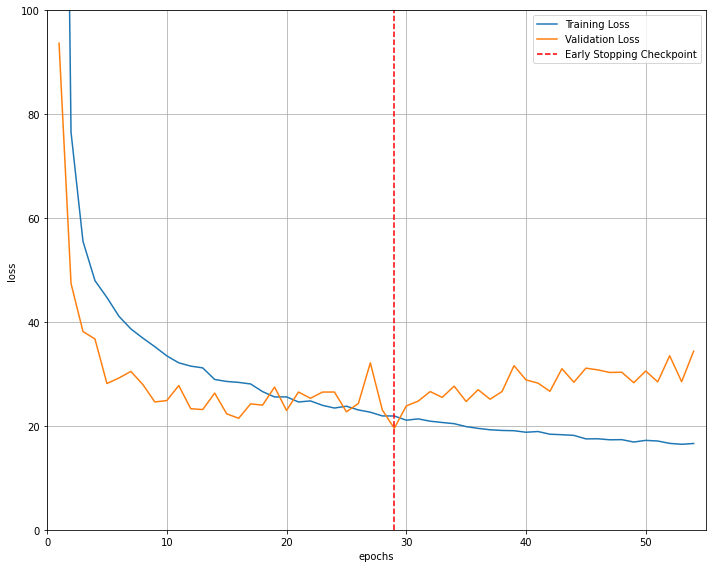

In [17]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = valid_loss.index(min(valid_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 100) # consistent scale
plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

In [0]:
def test(net):
    predictions = []
    with torch.no_grad():
        for i, sample in enumerate(testloader):
            predict = []
            x ,y = sample
            x = x.view(-1, IMG_CHANNELS, IMG_SIZE, IMG_SIZE)
            
            x = x.to(device)
            y = y.to(device)
            
            a, b, y_p, d = net(x)

            #get class of a, b, d
            _, aa = a.max(1)
            _, bb = b.max(1)
            _, dd = d.max(1)

            aa = aa.to("cpu")
            bb = bb.to("cpu")
            y_p = y_p.to("cpu")
            dd = dd.to("cpu")

            predict.append(aa)
            predict.append(bb)
            predict.append(y_p)
            predict.append(dd)
            predict = np.array(predict)
            predictions.append(predict)
            

    #print(predictions)
    #print()
    predictions = np.array(predictions)
    predictions = predictions.reshape(-1, OUTPUT_LABEL_SIZE)
    df = DataFrame(predictions)
    df.to_excel('predictions.xlsx', header=None)

In [21]:
testsets = []
for f in tqdm(os.listdir(TEST_PATH_LABEL)):
  path  = os.path.join(TEST_PATH_LABEL, f)
  testset = DataCaller_Excel(path, IMG_SIZE)
  print(testset.__len__())
  testsets.append(testset)

testset = ConcatDataset(testsets)



  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:12<00:00, 12.90s/it]

200


In [0]:
testloader = DataLoader(testset, batch_size=1, shuffle=False)
trained_net = Net()
trained_net.load_state_dict(torch.load(LOAD_PRETRAINED_PATH))
trained_net.to(device)
trained_net.eval()
test(trained_net)